### 1.0 Background

**1.1 Project Overview**

Sparkify - an online streaming company - has millions of users that stream their music every day. Their customers fall into two categories - free-tier customers get to listen to advertisements between the songs while premium subscribers stream music advertisement-free but have to pay a premium flat rate. Users can upgrade, downgrade or cancel their service at anytime. As a result, it is important to ensure users enjoy the service.


**1.2 Problem Statement**

The goal of this project is to predict customers that are at risk of churn. A customer churns when they downgraded from premium to free-tier or cancel their service altogether. Given it is far more expensive to acquire new customers than to retain existing ones, churn correlates with lost revenue and increased acquisition spend. By accurately predicting customers at risk of churn, the business can take proactive steps to retain the customers by offering them incentives and/or discounts thereby saving the company millions in revenue.

To approach this, i will tag custom

**1.3 Metrics**

Accuracy will be used to measure the quality of predictions. Accuracy is defined as the proportion of correct predictions. 

ROC_AUC might be used depending on the balance of the dataset

In [89]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, col, max, min, avg, stddev,count, isnull, udf, sum, split, regexp_replace,regexp_extract, element_at, from_unixtime, from_utc_timestamp, concat_ws,substring, year, month
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier,LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import time
import seaborn as sns
from utilities import *
import datetime
import re
import numpy as np

### 2.0 Load and Clean data

In [2]:
#start a pyspark session
spark = SparkSession\
    .builder\
    .appName('Sparkify')\
    .getOrCreate()

df = spark.read.json('data/medium-sparkify-event-data.json')

In [3]:
# Data summary
print('Data summary')
print('Number of users: {}'.format(df.select('userId').dropDuplicates().count()))
print('Number of interactions: {}'.format(df.count()))
print('Number of artists: {}'.format(df.select('artist').dropDuplicates().count()))
print('Number of songs played: {}'.format(df.select('song').dropDuplicates().count()))
print('Most played artist: {}. Played: {} times'.format(*(df.groupBy('artist').agg({'artist':'count'}).sort(col('count(artist)').desc()).collect()[0])))
print('Most played song: {}. Played: {} times'.format(*(df.groupBy('song').agg({'song':'count'}).sort(col('count(song)').desc()).collect()[0])))

Data summary
Number of users: 449
Number of interactions: 543705
Number of artists: 21248
Number of songs played: 80293
Most played artist: Kings Of Leon. Played: 3497 times
Most played song: You're The One. Played: 2219 times


In [4]:
hour_format = udf(lambda field:datetime.datetime.fromtimestamp(field/1000.0).hour)
year_format = udf(lambda field:datetime.datetime.fromtimestamp(field/1000.0).year)
month_format = udf(lambda field:datetime.datetime.fromtimestamp(field/1000.0).month)
df = df.withColumn('interactionHour',hour_format(df.ts))
df = df.withColumn('InteractionYear',year_format(df.ts))
df = df.withColumn('InteractionMonth',month_format(df.ts))
df = df.withColumn("unix_timestamp", concat_ws(".",from_unixtime(substring(col("ts"),0,10),"yyyy-MM-dd HH:mm:ss"),substring(col("ts"),-3,3)))

# derive state
df = df.withColumn('state',split(df.location, ', ')[1])
df = df.withColumn('city', split(df.location,',')[0])

# derive browser and remove quotation marks
df = df.withColumn('mozillaCompatible',regexp_replace(split(df.userAgent,' ')[0], r"\"",''))
df = df.withColumn('osPlatform', regexp_extract(df.userAgent, r"\((\w{3,}.+?);",1))
df = df.withColumn('os', element_at(split(df.osPlatform, ';'),-1))
df = df.withColumn('browserAndVersion',regexp_replace(element_at(split(df.userAgent, " "),-1),r"\"",""))
df = df.withColumn('browser',element_at(split(df.browserAndVersion, '/'),1))

df = df.drop('osPlatform')

**2.1 Missing value analysis**

In [5]:
# let's take a look at the number of missing values by field
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+---------------+---------------+----------------+--------------+-----+-----+-----------------+-----+-----------------+-------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|interactionHour|InteractionYear|InteractionMonth|unix_timestamp|state| city|mozillaCompatible|   os|browserAndVersion|browser|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+---------------+---------------+----------------+--------------+-----+-----+-----------------+-----+-----------------+-------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|              0|              0|       

In [6]:
# in a bid to try and understand why artist names are null
df.filter(col('artist').isNull()).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+---------------+---------------+----------------+--------------------+-----+--------------------+-----------------+--------------+-----------------+-------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|interactionHour|InteractionYear|InteractionMonth|      unix_timestamp|state|                city|mozillaCompatible|            os|browserAndVersion|browser|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+---------------+---------------+----------------+--------------------+-----+--------------------+-------

### 3.0 Exploratory Data Analysis

**3.1 Define Churn**

For this piece, churn is defined as a `cancellation confirmation`

In [7]:
# affix target label
affix_label = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn', affix_label(df.page))

In [8]:
# distribution of target event
pd_df = get_counts_pddf(column='churn',inputDf=df, idField='userId')
pd_df['churnPerc'] = pd_df['count'].div(pd_df['count'].sum(axis=0))
pd_df

,count,churnPerc
churn,,
0,543606,0.999818
1,99,0.000182


Less than 1% of all interactions lead to churn. It will be interesting to see this rolled up to the customer

**3.2 Charts**

Here i'll look at some charts to understand some of the patterns in the data

**Which gender has the greatest interaction with Sparkify?**

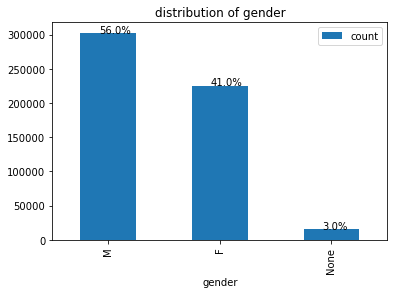

In [9]:
pd_summary_df = get_counts_pddf(column='gender',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='distribution of gender')

- Females account for 56% of all 543705 interactions on sparkify
- 3% of user interactions come from users who haven't disclosed their Gender

**Who are the most popular artists played on Sparkify?**

In [10]:
pd_summary_df = get_counts_pddf(column='artist',inputDf=df, idField='userId')

**What proportion of interactions come from paid subscriptions?**

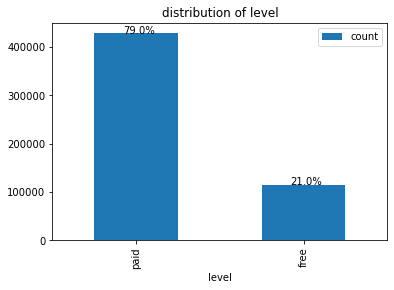

In [11]:
pd_summary_df = get_counts_pddf(column='level',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='distribution of level')

- 79% of all interactions on Spotify come from users with Paid subscriptions, while only 21% come from unpaid subscriptions

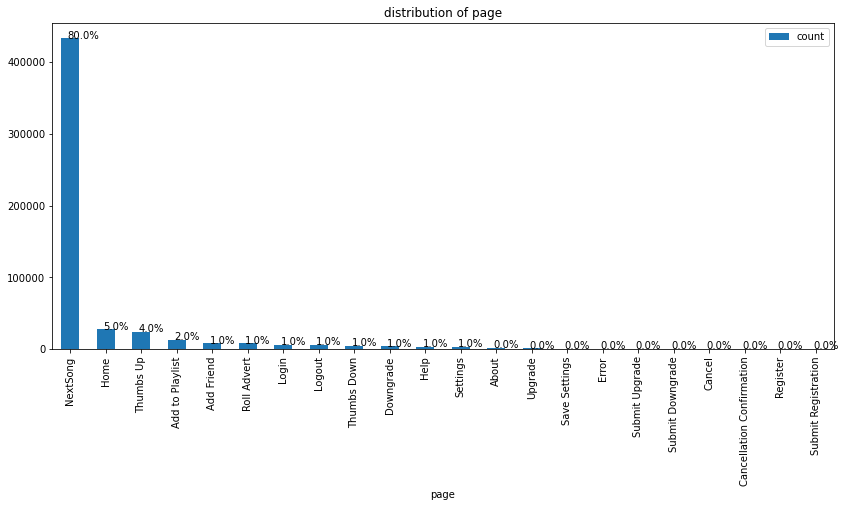

In [12]:
pd_summary_df = get_counts_pddf(column='page',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='distribution of page')

- 8 out of 10 of all users of sparkify play the next song
- on average 1% of the activity on Sparkify lead to a downgrade whereas 0% lead to upgrade. It will be interesting to what percentage of customers this translates to
- Only 1% of activity on Sparkify lead to Friend's being added. It sesms there's an opportuntity to improve user experience to drive addition of friends and addition to playlist.
- only 2% add songs to playlist. It will be nice to know whether there's an opportunity to improve the layout to make it easier to add songs to playlist

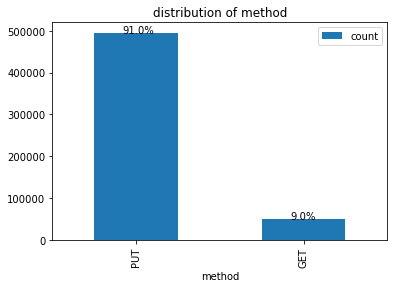

In [13]:
pd_summary_df = get_counts_pddf(column='method',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='distribution of method')

In [14]:
pd_summary_df = get_counts_pddf(column='song',inputDf=df, idField='userId')


Text(0.5, 1.0, 'top 30 most common songs played')

/Users/paulfru/miniconda3/envs/pyspark_env/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paulfru/miniconda3/envs/pyspark_env/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


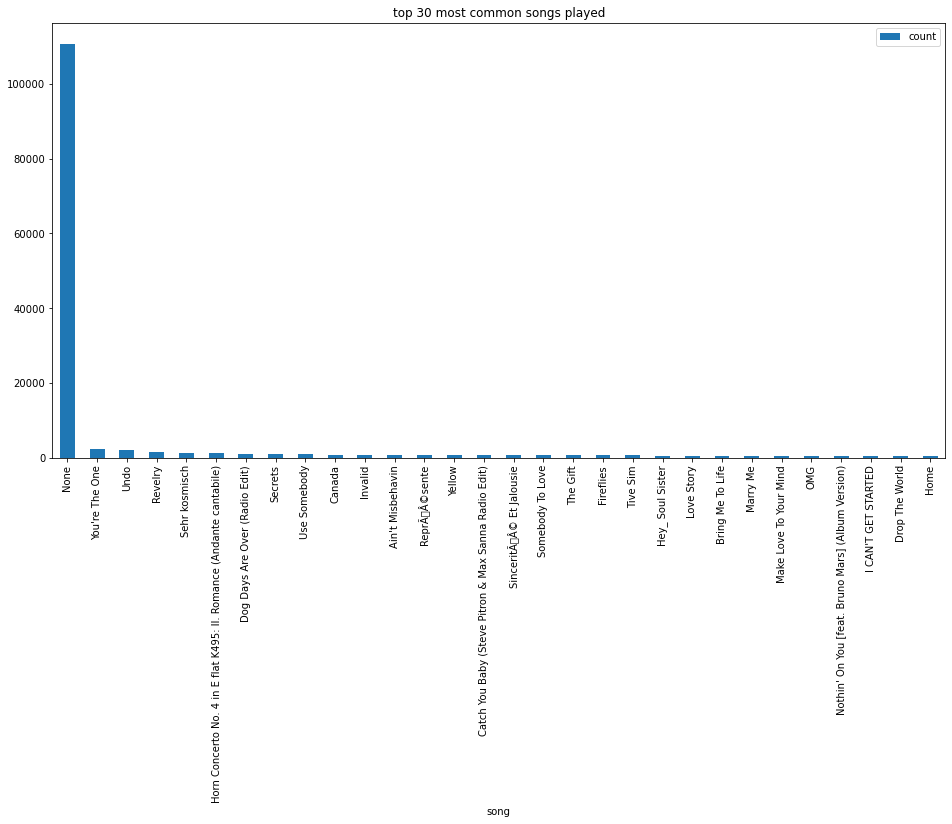

In [15]:
temp = pd_summary_df.iloc[:30].copy()
temp.plot(kind='bar', figsize=(16,8))
plt.title('top 30 most common songs played')

- Most users of Sparkify dont play any song
- Out of 80293 songs played on Sparkify, You're The One is the most played

**Which broswer channels the most customers into Sparkify**

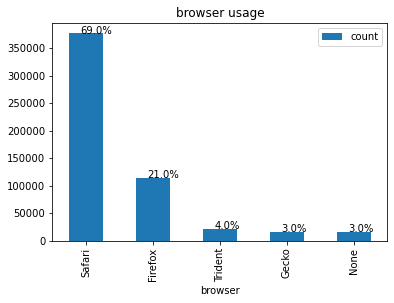

In [16]:
pd_summary_df = get_counts_pddf(column='browser',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='browser usage')

- About 70% of all interaction with Sparkify is done viea Safari, and 21% by Firefox browser

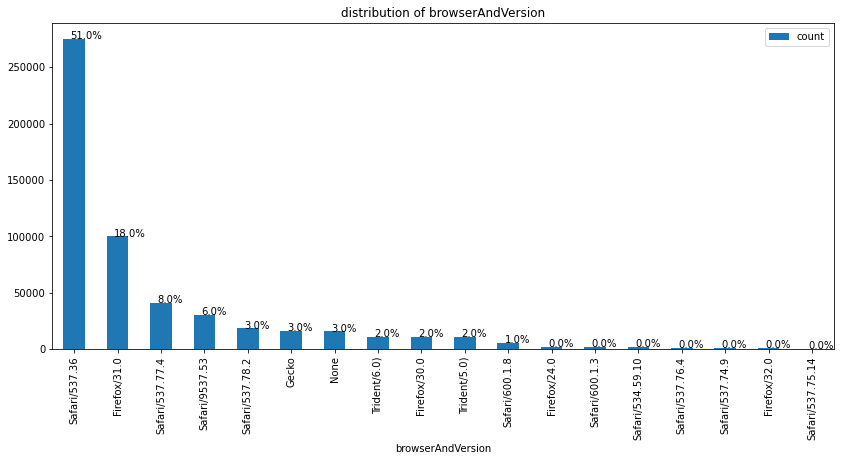

In [17]:
pd_summary_df = get_counts_pddf(column='browserAndVersion',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='distribution of browserAndVersion')

**3.3 Likelihood to churn - Out of every 10,000 user interactions how many churn?**

- Females are slightly more likely to churn than men. 2 out of every 10,000 females churn and only 1.78 out of every 10,000 males churn

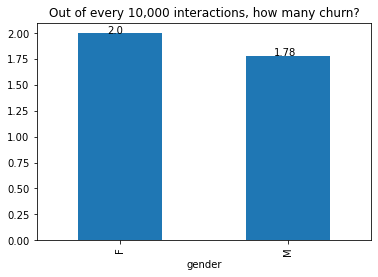

In [18]:
churn_df = churn_per_10k(inputDf=df, catCol='gender', churnCol='churn')
# churn_df
plot_churnper10k(inputDf=churn_df, churnPer10k='churnPer10k')

**Is there any association between subscription plan and churn?**

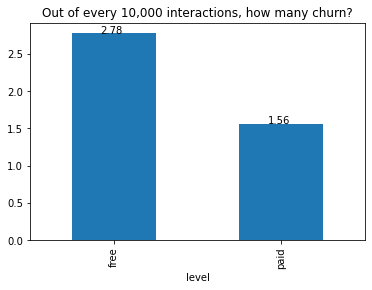

In [19]:
churn_df = churn_per_10k(inputDf=df, catCol='level', churnCol='churn')
plot_churnper10k(inputDf=churn_df, churnPer10k='churnPer10k')

- This is interesting, those on free tier plans seem to be more likely to churn than those on paid subscriptions.

**Interaction hour**

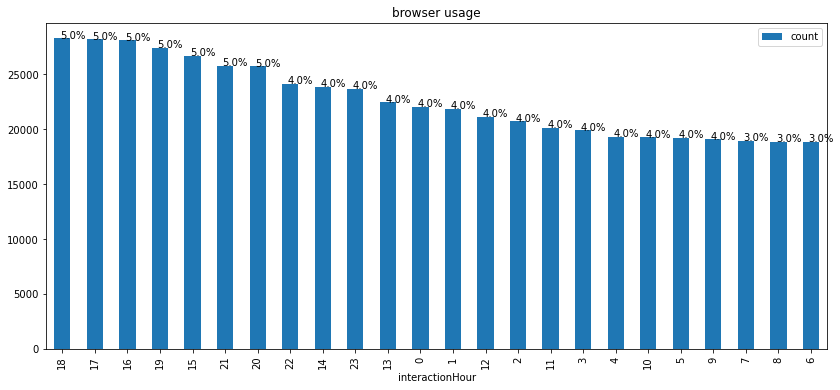

In [20]:
pd_summary_df = get_counts_pddf(column='interactionHour',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='browser usage')

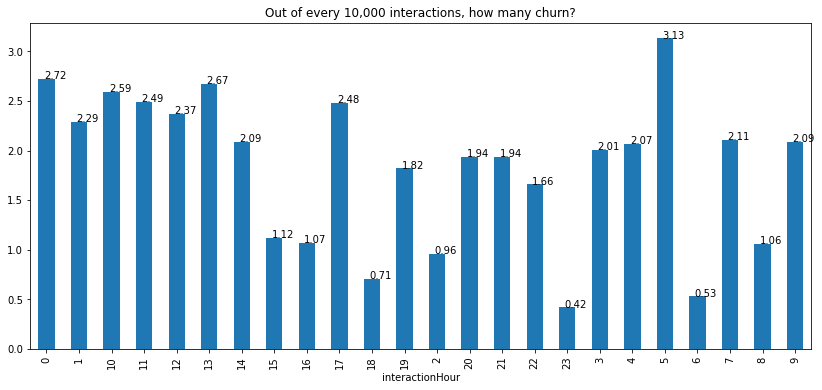

In [21]:
churn_df = churn_per_10k(inputDf=df, catCol='interactionHour', churnCol='churn')
plot_churnper10k(inputDf=churn_df, churnPer10k='churnPer10k')

- on average, relatively higher churn rates are observed at 5am, 5pm, 1pm and midnight - 1am

**Does the OS platform have any association with churn?**

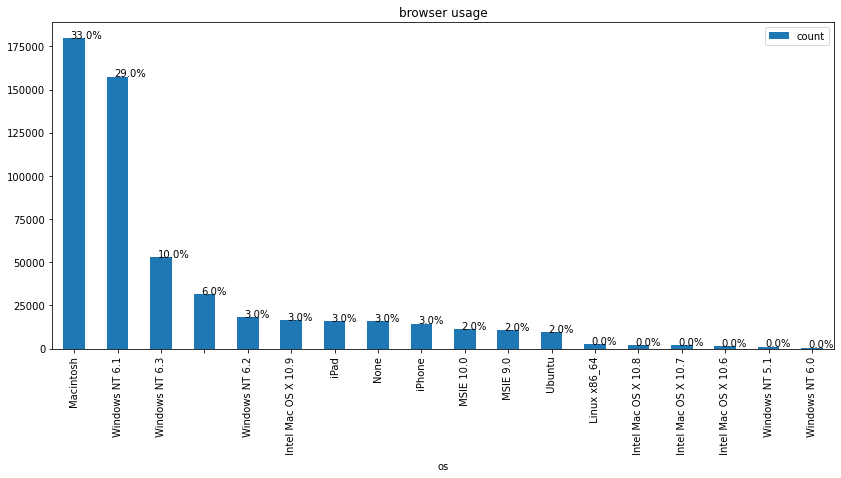

In [22]:
pd_summary_df = get_counts_pddf(column='os',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='browser usage')

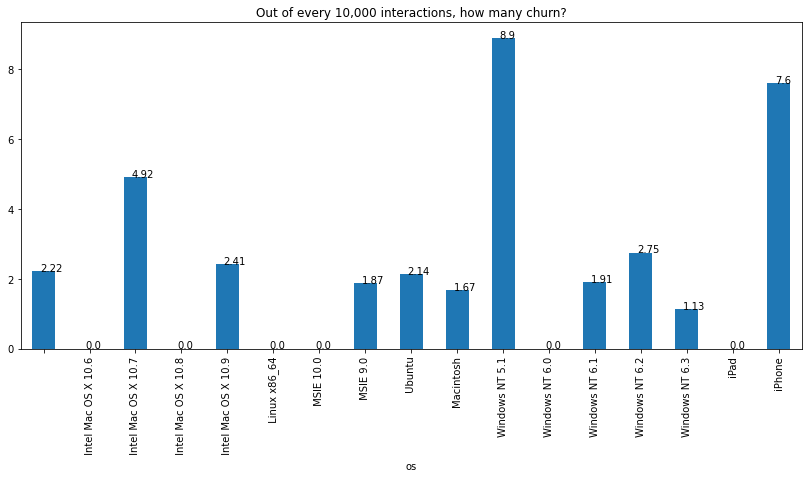

In [23]:
churn_df = churn_per_10k(inputDf=df, catCol='os', churnCol='churn')
plot_churnper10k(inputDf=churn_df, churnPer10k='churnPer10k')

- iphone users and earlier versions of Windows seem to be associated with a higher levels of churn
- The sparkify website might not be optimised for iphone users.

**Http response codes**

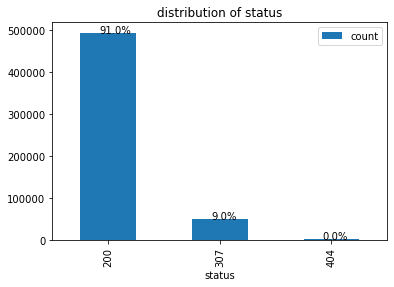

In [24]:
pd_summary_df = get_counts_pddf(column='status',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='distribution of status')

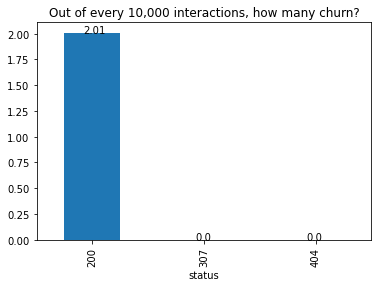

In [25]:
churn_df = churn_per_10k(inputDf=df, catCol='status', churnCol='churn')
plot_churnper10k(inputDf=churn_df, churnPer10k='churnPer10k')

The HTTP response codes mean the following:

- 200: Successful responses
- 307: Redirects
- 404: Client Errors

91% of all HTTP requests to Sparkify were succesful

**Which browsers channels the most users to Sparkify and what's the association between browser and churn**

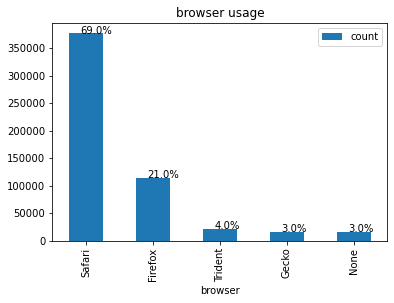

In [26]:
pd_summary_df = get_counts_pddf(column='browser',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='browser usage')

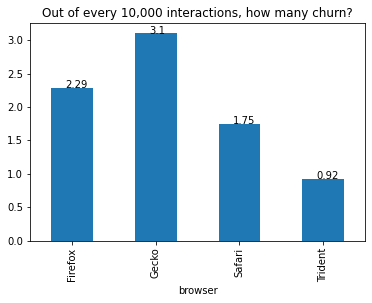

In [27]:
churn_df = churn_per_10k(inputDf=df, catCol='browser', churnCol='churn')
plot_churnper10k(inputDf=churn_df, churnPer10k='churnPer10k')

- About 70% of all interactions with Sparkify are done via Safari
- Interestingly, there seem to be an association between browser and churn.
- Users who access Sparkify through Trident are least likely to churn while user who access Sparkify through Gecko are most likely to churn

**Does the month of interaction have any impact on churn?**

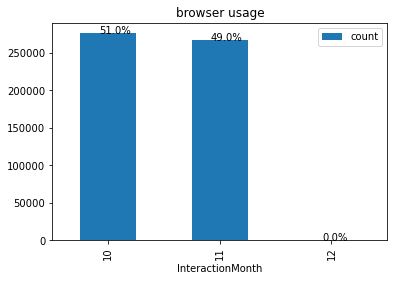

In [28]:
pd_summary_df = get_counts_pddf(column='InteractionMonth',inputDf=df, idField='userId')
bar_plot(pd_summary_df, title='browser usage')

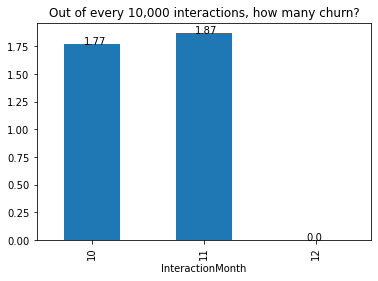

In [29]:
churn_df = churn_per_10k(inputDf=df, catCol='InteractionMonth', churnCol='churn')
plot_churnper10k(inputDf=churn_df, churnPer10k='churnPer10k')

- Our dataset only contains interactions that took place in October, November and December
- 51% of all interactions with Sparkify happened in October and 49% in November
- The churn in November was higher per 10,000 interactions than it was in October

**3.4 Feature Creation**

Before creating more features, data will be aggregated to UserId

In [30]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- interactionHour: string (nullable = true)
 |-- InteractionYear: string (nullable = true)
 |-- InteractionMonth: string (nullable = true)
 |-- unix_timestamp: string (nullable = false)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- mozillaCompatible: string (nullable = t

First, let's see an example of the log of a customer who churns

In [31]:
# create list of churn ids
churnUserIds = df.filter(col('churn')==1).select('userId').collect()
churnUserIdList = [id[0] for id in churnUserIds]

# get count of interactions by churners - the goal her is to inspect churners with a manageable number of interactions that can be displayed comfortable
leastInteractiveChurner = df.filter(col('userID').isin(churnUserIdList)).groupBy('userID').agg(count('userID').alias('count')).sort(col('count').asc()).collect()[0][0]

# inspect interactions of least interactive user with Sparkify
df.filter(col('userId')==leastInteractiveChurner)\
    .select(['auth','firstName','gender','itemInSession','length','level','method','page','registration','sessionId','status','ts','userId','interactionHour','churn','os','unix_timestamp'])\
    .show(50)

+---------+---------+------+-------------+---------+-----+------+--------------------+-------------+---------+------+-------------+------+---------------+-----+--------------+--------------------+
|     auth|firstName|gender|itemInSession|   length|level|method|                page| registration|sessionId|status|           ts|userId|interactionHour|churn|            os|      unix_timestamp|
+---------+---------+------+-------------+---------+-----+------+--------------------+-------------+---------+------+-------------+------+---------------+-----+--------------+--------------------+
|Logged In|     Iker|     M|            0|224.65261| free|   PUT|            NextSong|1532081444000|       32|   200|1538645301000|100032|             10|    0|Windows NT 6.1|2018-10-04 10:28:...|
|Logged In|     Iker|     M|            1|     null| free|   GET|         Roll Advert|1532081444000|       32|   200|1538645373000|100032|             10|    0|Windows NT 6.1|2018-10-04 10:29:...|
|Logged In|    

In [33]:
df.createOrReplaceTempView('sql_view')

In [34]:
# to compute: tenure of customer 
#     level,
#     state,
qry = """select 
    userId,
    gender,
    state,
    city,
    max(itemInSession) as numSessions,
    count(distinct song) as numSongs,
    round(mean(length),2) as avgLength,
    count(distinct artist) as numArtists,
    sum(case when page='Thumbs Down' then 1 else 0 end) as numThumbsDown,
    sum(case when page='Downgrade' then 1 else 0 end) as numDowngrades,
    sum(case when page='Roll Advert' then 1 else 0 end) as numRolladvert,
    sum(case when page='NextSong' then 1 else 0 end) as numNextSongs,
    sum(case when page='Home' then 1 else 0 end) as numHomePageVisits,
    sum(case when page='Thumbs Up' then 1 else 0 end) as numThumbsUp,
    sum(case when page='Add to Playlist' then 1 else 0 end) as numPlaylistAdds,
    sum(case when page='Add Friend' then 1 else 0 end) as numFriendsAdded,
    sum(case when page='Login' then 1 else 0 end) as numLogins,
    sum(case when page='Logout' then 1 else 0 end) as numLogouts,
    sum(case when page='Help' then 1 else 0 end) as numHelps,
    sum(case when page='Settings' then 1 else 0 end) as numSettings,
    sum(case when page='Error' then 1 else 0 end) as numErrors,
    sum(case when page='About' then 1 else 0 end) as numAboutVisits,
    sum(case when browser='Safari' then 1 else 0 end) as numSafari,
    sum(case when browser='Firefox' then 1 else 0 end) as numFirefox,
    sum(case when browser='Trident' then 1 else 0 end) as numTrident,
    sum(case when upper(os) like '%WINDOWS%' then 1 else 0 end) as numWindowsConnections,
    sum(case when upper(os) like '%IPHONE%' then 1 else 0 end) as numIphoneConnections,
    sum(case when upper(os) like '%UBUNTU%' then 1 else 0 end) as numUbuntuConnections,
    sum(case when upper(os) like '%LINUX%' then 1 else 0 end) as numLinuxConnections,
    sum(case when upper(os) like '%MAC%' then 1 else 0 end) as numMacConnections,
    max(interactionHour) as latestInteractionTime,
    min(interactionHour) as earliestInteractionTime,
    count(distinct browser) as numBrowsers,
    count(distinct os) as numOs,
    case when sum(churn)=1 then 1 else 0 end as Churn
from sql_view
group by 1,2,3,4
"""

df_agg = spark.sql(qry)

In [35]:
df_agg.count()

449

**3.5 More exploratory analysis at user level**

The earlier analysis was done at a transactional level, based on each interaction a user had with spotify.

Here I will do the analysis at the customer level

**3.4.1 Class distribution of Churn - user level**

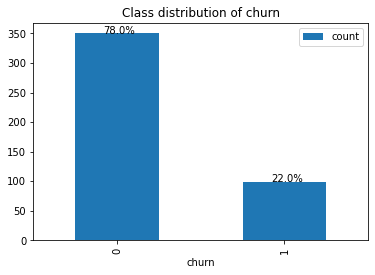

In [36]:
temp = get_counts_pddf(column='churn', inputDf=df_agg, idField='userId')
bar_plot(inputDf=temp, title='Class distribution of churn')

- out of 449 users, 22% have churned
- this is quit a high number. 

In the proceeding steps, we'll investigate potential drivers of churn

**3.4.2 what is the impact of avg length on churn?**

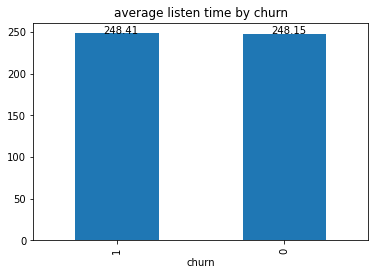

In [37]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='avgLength')
bar(pd_df, 'average listen time by churn')

The average length is the same for both churners and non-churners, suggesting this feature doesn't drive churn

**3.4.3 Number of sessions seems to have very little impact on churn**

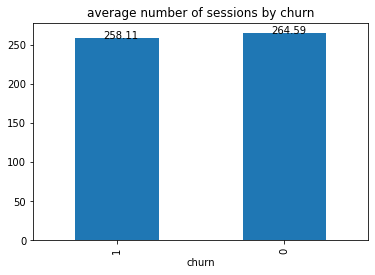

In [38]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numSessions')
bar(pd_df, 'average number of sessions by churn')

**3.4.4. On average churners listen to more music than non-churners**

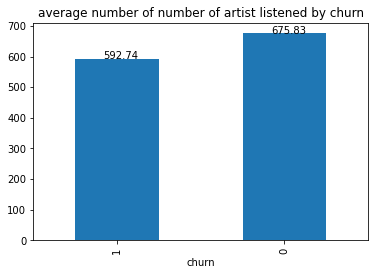

In [39]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numArtists')
bar(pd_df, 'average number of number of artist listened by churn')

- This makes sense because those who churn have shorter tenures

**3.4.5. The average number of thumbs down for churners is very similar to non churners**

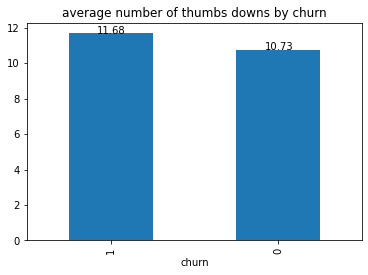

In [40]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numThumbsDown')
bar(pd_df, 'average number of thumbs downs by churn')

**3.4.6 Average number of downgrades is consistent across segments**

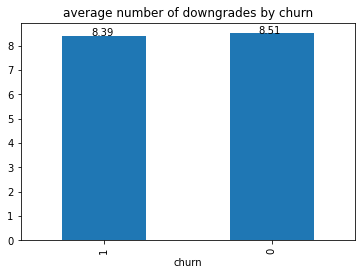

In [41]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numDowngrades')
bar(pd_df, 'average number of downgrades by churn')

**3.4.7 Churners have a much higher number of roll adverts on average**

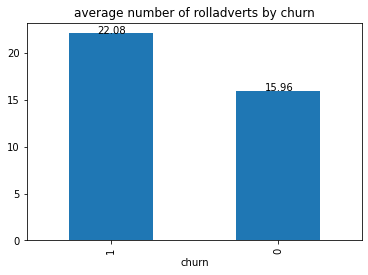

In [42]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numRolladvert')
bar(pd_df, 'average number of rolladverts by churn')

**3.4.8Churners dont play as many songs as non churners**

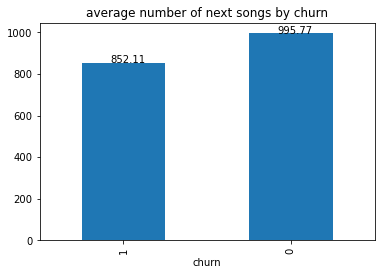

In [43]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numNextSongs')
bar(pd_df, 'average number of next songs by churn')

**3.4.9 The average number of home page visits is higher with non churners**

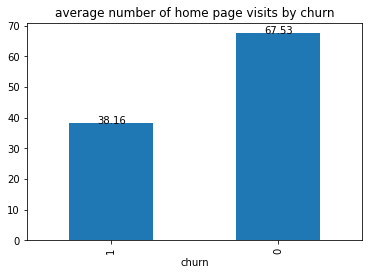

In [44]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numHomePageVisits')
bar(pd_df, 'average number of home page visits by churn')

**3.5.0 The average number of thumbs ups is lower for churners**

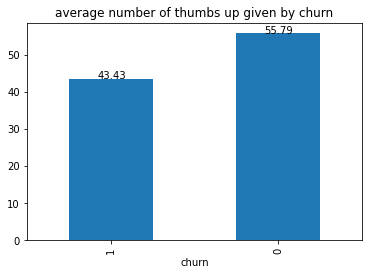

In [45]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numThumbsUp')
bar(pd_df, 'average number of thumbs up given by churn')

**3.5.1 Non churners add fewer playlists on average**

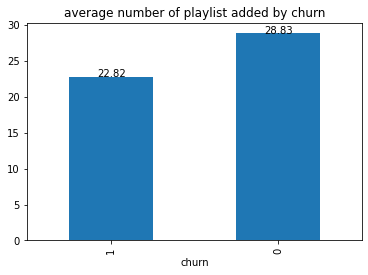

In [46]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numPlaylistAdds')
bar(pd_df, 'average number of playlist added by churn')

**3.5.2 On average non-chuners add about 17 logins vs 0 for churners**

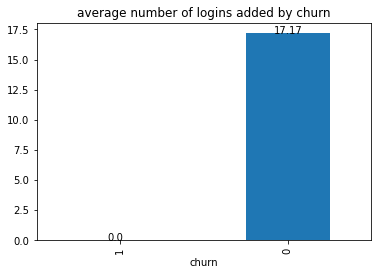

In [47]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numLogins')
bar(pd_df, 'average number of logins added by churn')

**3.5.3 On average churners dont logout whereas non-churners logout significantly more**

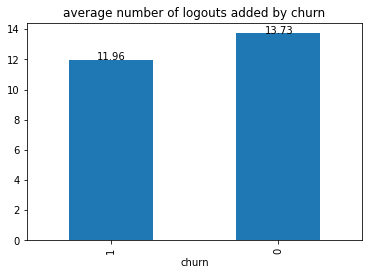

In [48]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numLogouts')
bar(pd_df, 'average number of logouts added by churn')

**3.5.4 Non-churners seek more help on average than churners**

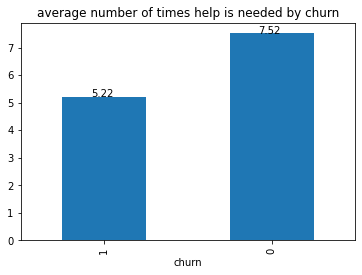

In [49]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numHelps')
bar(pd_df, 'average number of times help is needed by churn')

**3.5.5 On average churners encounter less errors than non-churners**

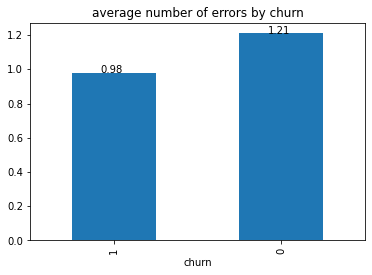

In [50]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numErrors')
bar(pd_df, 'average number of errors by churn')

**3.5.6. Those who connect to Sparkify on windows systems are more likely to churn than those who dont**

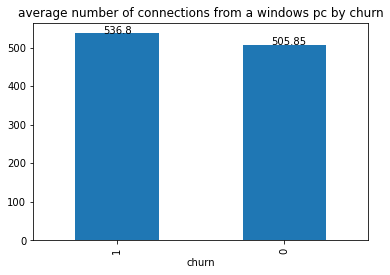

In [51]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numWindowsConnections')
bar(pd_df, 'average number of connections from a windows pc by churn')

**3.5.7 On average, iphone users of sparkify have a significantly higher churn rate vs non-iphone users**

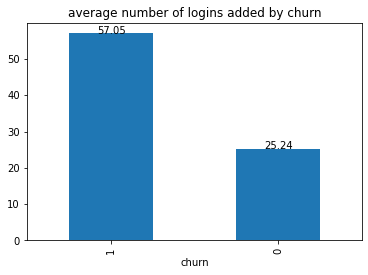

In [52]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numIphoneConnections')
bar(pd_df, 'average number of logins added by churn')

**3.5.8 Churners play far fewer songs on average then non-churners**

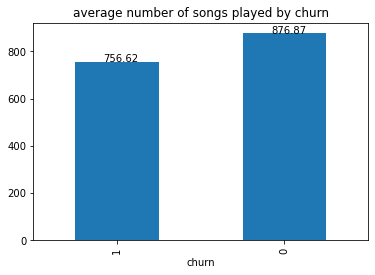

In [53]:
pd_df = agg_by_churn(inputDf=df_agg, churnCol='churn', numericCol='numSongs')
bar(pd_df, 'average number of songs played by churn')

In [54]:
pd_df = df_agg.toPandas()

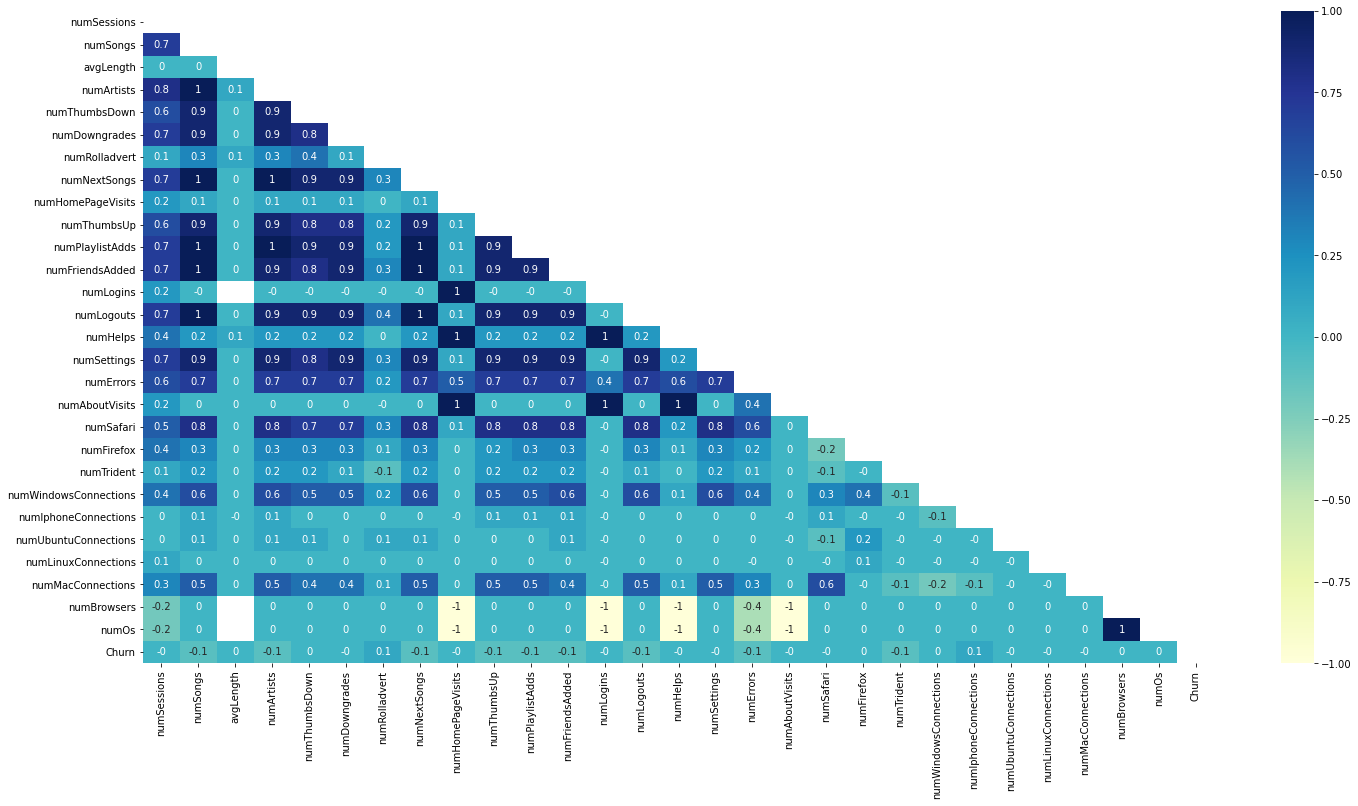

In [55]:
# creating mask
mask = np.triu(np.ones_like(pd_df.corr()))
  
# plotting a triangle correlation heatmap
plt.figure(figsize=(24,12))
dataplot = sns.heatmap(round(pd_df.corr(),1), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

Based on the EDA, i will only keep the below features as they seem to be indicative of Churn. I have removed the features that are correlated to each other based on the heatmap above

In [56]:
# list of features include demographic features and target field
feature_subset = ['gender',
                 'numSongs',
                 'numArtists',
                 'numRolladvert',
                 'numHomePageVisits',
                 'numThumbsUp',
                 'numLogins',
                 'numHelps',
                 'numErrors',
                 'numAboutVisits',
                 'numWindowsConnections',
                 'numIphoneConnections',
                 'Churn']

### 4.0 MODELING

Here I'll split the data into train and test sets, then build separate pipelines for the Logistic Regression, Random Forest and Gradient-Boosted Tree classifiers. I will then tune each pipeline and select the model with the best F1 score as my champion mode.

**4.1 Check for presence of missing values first**

In [57]:
modelling_df = df_agg.select(feature_subset)

In [59]:
modelling_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in modelling_df.columns)).show()

+------+--------+----------+-------------+-----------------+-----------+---------+--------+---------+--------------+---------------------+--------------------+-----+
|gender|numSongs|numArtists|numRolladvert|numHomePageVisits|numThumbsUp|numLogins|numHelps|numErrors|numAboutVisits|numWindowsConnections|numIphoneConnections|Churn|
+------+--------+----------+-------------+-----------------+-----------+---------+--------+---------+--------------+---------------------+--------------------+-----+
|     1|       0|         0|            0|                0|          0|        0|       0|        0|             0|                    0|                   0|    0|
+------+--------+----------+-------------+-----------------+-----------+---------+--------+---------+--------------+---------------------+--------------------+-----+



Gender still has a missing value. To correct for this, i will impute with the most frequent gender

In [60]:
mostCommonGender = modelling_df.groupBy('gender').agg(count('gender').alias('count')).sort(col('count').desc()).collect()[0][0]
# impute
modelling_df = modelling_df.fillna({'gender':mostCommonGender})

In [61]:
indexer = StringIndexer(inputCols=['gender'], outputCols = ['genderIndex'])
modelling_df = indexer.fit(modelling_df).transform(modelling_df)

**4.2 split data into train test sets**

In [65]:
training, test = modelling_df.randomSplit([0.8, 0.2])

**4.3 Build pipeline**

This will be the start of model selection. Here, a number of pipelines are setup for different models. One for a Logistic Regression, another for a Random Forest model and a final pipeline for a Gradient Boosted tree classifier. These pipelines are setup at the model level to enable the entire pipeline of each classifier to be tunned all at once, rather than element-by-element. The pipeline with the highest performance based on average F1 score will be chosen as final model

In [62]:
# create Vector Assembler to push features into ML
assembler = VectorAssembler(inputCols=['numSongs','numArtists','numRolladvert','numHomePageVisits','numThumbsUp','numLogins','numHelps','numErrors',\
                                       'numAboutVisits','numWindowsConnections','numIphoneConnections','genderIndex'], outputCol='featuresVec')

# lets normalize data
scaler = Normalizer(inputCol = 'featuresVec', outputCol='scaledFeatures')

In [90]:
# Let's try fitting a number of models - Logistic Regression, random forest and GradientBoosted Trees
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='Churn', regParam=0.01, elasticNetParam=0)
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='Churn')
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='Churn')
svc = LinearSVC()

In [97]:
# Create pipeline
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])
# pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])
pipeline_svc = Pipeline(stages=[assembler, scaler,rf])

In [94]:
# create param grid for Logistic Regression
paramGridLr = ParamGridBuilder()\
    .addGrid(lr.regParam,[0.0, 0.05, 0.1])\
    .build()

paramGridRf = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [5,8,11])\
    .addGrid(rf.numTrees, [20, 25, 30])\
    .build()

paramGridGbt = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5,8,11])\
    .addGrid(gbt.maxIter, [20,30,40])\
    .build()

paramGridSvc = ParamGridBuilder()\
    .addGrid(svc.maxIter, [10,100,500])\
    .addGrid(svc.regParam, [0.01,0.1,10.0,100.0])\
    .build()

In [85]:
def tune_fit_pipline(modelPipeline, paramGrid, trainDf, pipelineAlias, label):
    """This fits the pipeline to training data and outputs the fitted model
    
    Input
    modelPipeline: model-specifice pipeline
    paramGrid: model-sspecifice parameter grid object 
    trainDf: train set
    pipelineAlias: (str)  alias for the pipeline
    label: (str) label column - Churn
    
    Output: trained model"""
    crossval = CrossValidator(estimator=modelPipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(labelCol=label),
                              numFolds=3)
    
    start_time = time.time()  #start time of training
    model = crossval.fit(trainDf)  #training
    end_time = time.time()
    
    print('Train time for {0}: {1}'.format(pipelineAlias, end_time - start_time))
    print('Average F1 score: {}'.format(np.mean(model.avgMetrics)))
    
    return model

In [86]:
rf_model = tune_fit_pipline(modelPipeline=pipeline_rf, paramGrid=paramGridRf, trainDf=training, pipelineAlias='Random Forest', label='Churn')

Train time for Random Forest: 689.7868287563324
Average F1 score: 0.7145016466243228


In [92]:
# gbt_model = tune_fit_pipline(modelPipeline=pipeline_gbt, paramGrid=paramGridGbt, trainDf=training, pipelineAlias='Gradient Boosted Tree', label='Churn')

In [88]:
lr_model = tune_fit_pipline(modelPipeline=pipeline_lr, paramGrid=paramGridLr, trainDf=training, pipelineAlias='Logistic Regression', label='Churn')

Train time for Logistic Regression: 988.2502398490906
Average F1 score: 0.701384036365547


In [98]:
svc_model = tune_fit_pipline(modelPipeline=pipeline_svc, paramGrid=paramGridSvc, trainDf=training, pipelineAlias='Support Vec Classifier', label='Churn')

Train time for Support Vec Classifier: 528.5793962478638
Average F1 score: 0.7271948758581196


### Test model performance

In [108]:
def model_performance_score(metric, label, testDf, inputModel):
    """Computes and returns a model performance score
    
    input
    metric: (str) metric to compute. Should be either accuracy or fa
    label: target label. In this case Churn
    testDf: test data on which to measure model performance
    inputModel: model to use. One of the model pipelines
    
    Output: returns the test score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric, labelCol=label)
    modelResults = inputModel.transform(testDf)

    # find f1 score
    score = evaluator.evaluate(modelResults)

    return score

In [118]:
# Let's see what the f1 scores are on the testing set
print('F1 score on testing set\n======================================================')
print('Random Forest: {}'.format(model_performance_score(metric='f1', label='Churn', testDf=test, inputModel=rf_model)))
print('Support Vec Classifier: {}'.format(model_performance_score(metric='f1', label='Churn', testDf=test, inputModel=svc_model)))
print('Logistic Regression: {}'.format(model_performance_score(metric='f1', label='Churn', testDf=test, inputModel=lr_model)))

F1 score on testing set
Random Forest: 0.663265306122449
Support Vec Classifier: 0.6475777743383376
Logistic Regression: 0.693877551020408


In [117]:
# Let's see what the accuracy is
print('Accuracy score on testing set\n======================================================')
print('Random Forest: {}'.format(model_performance_score(metric='accuracy', label='Churn', testDf=test, inputModel=rf_model)))
print('Support Vec Classifier: {}'.format(model_performance_score(metric='accuracy', label='Churn', testDf=test, inputModel=svc_model)))
print('Logistic Regression: {}'.format(model_performance_score(metric='accuracy', label='Churn', testDf=test, inputModel=lr_model)))

Accuracy score on testing set
Random Forest: 0.7380952380952381
Support Vec Classifier: 0.7380952380952381
Logistic Regression: 0.7619047619047619


### Conclusion
In this notebook, i built a number of models to predict churn. In the course of cleaning the data i label encoded gender and to help with the predictions, i retained 12 features. With the help of VectorAssembler, these 12 features were combined to vectors. Only 3 models were selected: Logistic Regression, Random Forest, Support Vector Machines. The Logistic Regression outperformed the other models due to its higher F1 score value.

**Reflections**

This project has enabled me learn pyspark on my local machine. Due to the limitations of running a local instance of Pyspark, i used a subset of the original data to build the ML pipeline. What will be great to do is to migrate this model to AWS and use the full power of pyspark on the full dataset. This should offer some big gains in model performance.

One of the interesting, yet difficulties with the project was how limited the pyspark community is and the pyspark documentation is. As a result it took me longer to find answers to problems i was facing. Thanks to how Pyspark is structured, i was able to quickly switch to the spark sql API to help build modularised code.

**How will the model help**

This model predict customers that are likely to churn. With these predictions, Sparkify will have to proactively reach out to the customers and incentivise them to stay. Also, it will be beneficial for sparkify to engage the customer to understand how satisfied they are with Sparkify.

**Areas of Improvements**

To improve this model, i suggest running it on the original data (i.e. not a sample) and gauge it's performance. With a larger sample, the model should learn a lot more and therefore perform better.

Also, since there is only a small number of users who churn, there might be model gains if we oversample the target class using techniques such as SMOTE.

Also, the pipeline for this model seems custom-built for Logistic Regression. I Standardize features before running models on them. Standardization helps linear models but not tree models such as Random Forest. It might improve our model performance if we exclude the standardization step from the tree classifiers

